<b><font size=20, color='#A020F0'>Regridding with xESMF</font></b>

Hannah Zanowski<br>
11/04/24<br>

#### <span style="color:green">Learning Goals</span>
By the end of this notebook you will
1. Understand when regridding is necessary/useful
2. Become familiar with the basic types of regridding algorithms
3. Practice regridding using tools from xESMF

#### Resources
[xESMF Documentation](https://xesmf.readthedocs.io/en/latest/index.html)<br>

Other regridding tools:<br>
[Climate Data Operators (CDO)](https://www.climate-cryosphere.org/wiki/index.php?title=Regridding_with_CDO)<br>
[More regridding options from the xESMF site](https://xesmf.readthedocs.io/en/latest/other_tools.html) 
(includes Fortran options, NCL, NCO, etc)<br>

# A little about xESMF

xESMF is an xarray-based python package designed for regridding geospatial data. It was designed to make regridding a slightly more inuitive process, thereby removing the need to deal with the steeper learning curves with tools such as [ESMF](https://earthsystemmodeling.org/regrid/#ways-to-use-esmf-regridding) and [ESMPy](https://earthsystemmodeling.org/esmpy/). You can read more about the reasoning behind developing xESMF [here](https://xesmf.readthedocs.io/en/latest/why.html).

Let's begin by importing xESMF (and a few others):

In [1]:
import xesmf as xe
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

---

## 1. What is regridding?
Regridding is really just multi-dimensional interpolation, and as the word suggests, it is useful when you want to take data that sit on one grid and transform them to another. You can upscale a grid (i.e., go from a higher resolution to a lower resolution) or you can downscale (go from lower resolution to higher resolution) depending on your needs. Keep in mind that the latter adds no new information! The NCAR climate data guide has a [nice overview](https://climatedataguide.ucar.edu/climate-data-tools-and-analysis/regridding-overview) if you want to learn more.

### Types of grids
There are several types of grids that we typically come across when working with geospatial data, and many of you are probably familiar with the first two although you may not realize it:

1. <b>Rectilinear</b>--a rectilinear grid is a grid in which each cell is a rectangle. Each rectangle need not be the same size. (A special case of a rectilinear grid is a regular grid. Each grid cell is the same size on a regular grid.)

2. <b>Curvilinear</b>--a curvilinear grid is a grid made up of non-rectangular quadrilaterals (e.g., the lines on a globe are a curvilinear grid, hence why cylindrical and spherical coordinates are curvilinear coordinate systems; it just means the coordinate lines can be curved!)

3. <b>Unstructured</b>--some common forms of this are a "grid" made up of a tessellation of equilateral triangles or hexagons, like in [MPAS](https://ncar.ucar.edu/what-we-offer/models/model-prediction-across-scales-mpas)

<img src='Images/rectilinear.png' height=300 width=300></img> <img src='Images/curvilinear.png' height=300 width=300></img>  <img src='Images/unstructured_mesh.png' height=300 width=300></img> 

### Common types of regridding algorithms

1. <b><font color='green'>Nearest neighbors</font></b>--uses points closest to the grid point to do the regridding; can introduce new extrema<br>

   >1. <b>Nearest source to destination:</b> destination point mapped to closest source point (given a destination, what's the nearest source?); some source points can be excluded and a single source point can be mapped to multiple destinations! <br>
   
   >2. <b>Nearest destination to source:</b> source points mapped to closest destination point (given a source, what's the nearest destination?); some destinations will be excluded, and multiple sources can be mapped to the same destination (these are added together)!
   
2. <b><font color='green'>Bilinear</font></b>--linear interpolation in multiple dimensions; good for smoothly varying fields, not great for discontinuous fields

3. <b><font color='green'>Conservative</font></b>--conserves the integral of the source field during regridding; better for upscaling and computing fluxes

4. <b><font color='green'>Patch</font></b>--least squares fit of surrounding surface patches; good for when you need accurate derivatives; slower to implement

<b><font color='blue'>A few rules of thumb:</font></b><br>
1. In general, compute nonlinear quantities on the original grid before doing regridding operations
2. Compute fluxes on the original grid if you can as well, especially if you're computing budgets--it's really hard to get budgets to close if you regrid without thinking about the methodology you're using

---

## 2. Regridding with xESMF
xESMF supports the following regridding methods:

1. <b>Nearest Neighbors</b>--both nearest_s2d (nearest source to destination) and nearest_d2s (nearest destination to source)
2. <b>Bilinear</b>
3. <b>Conservative</b>
4. <b>Patch</b>

><b><font color='blue'>Note:</font></b> xESMF does not currently support regridding for unstructured meshes.

### Comparing regridding methods
The xESMF documentation has several [nice examples](https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html) that compare each of the above regridding algorithms for both the upscaling and downscaling cases. I've taken the example for the downscaling case and reproduced it here:

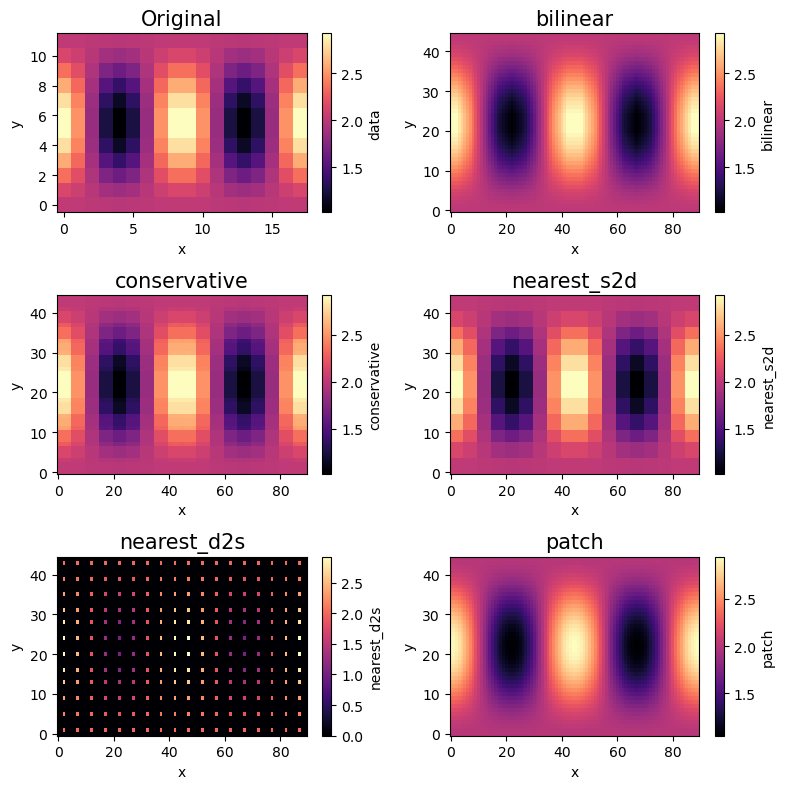

In [2]:
#List of regridding methods
methods=['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']

#Set up the grids
ds_in = xe.util.grid_global(20, 15)  # input grid
ds_fine = xe.util.grid_global(4, 4)  # high-resolution target grid

#Get some built-in data
ds_in['data'] = xe.data.wave_smooth(ds_in['lon'], ds_in['lat'])

#Define a regridding function to take in any method and grid and apply it on input data
def regrid(ds_in, ds_out, dr_in, method):
    """Convenience function for one-time regridding"""
    regridder = xe.Regridder(ds_in, ds_out, method, periodic=True)
    dr_out = regridder(dr_in)
    #regridder.clean_weight_file()
    return dr_out

#Do the regridding for each method in the list of methods
for method in methods:
    ds_fine[method] = regrid(ds_in, ds_fine, ds_in['data'], method)
    
#Plot the original data along with the regridded versions
cmap=plt.cm.magma
fig,ax=plt.subplots(3,2,figsize=(8,8))
axs=ax.flatten()
#plot the original data first
ds_in['data'].plot.pcolormesh(ax=axs[0],cmap=cmap)
axs[0].set_title('Original', fontsize=15)
for i, method in enumerate(methods,start=1):
    ds_fine[method].plot.pcolormesh(ax=axs[i],cmap=cmap)
    axs[i].set_title(method, fontsize=15)

plt.tight_layout()

---

#### <font color='blue'>Exercise for the class</font>
Compare the results of the regridding schemes. What do you notice about them? Which onces seem to perform well? Poorly?

---

### A "real world" example
In this section we'll go through the regridding process step-by-step so that you can see how it's done in more detail. We'll use an example from my own work, as regridding is a common process for anyone using climate model sea ice or ocean output from the Arctic. First let's read in the data, which, in this example is a 2D field of 1850-2015 mean sea ice concentration from CanESM5, one of the climate models participating in the [Coupled Model Intercomparison Project Phase 6](https://www.wcrp-climate.org/wgcm-cmip/wgcm-cmip6) (CMIP6):

In [3]:
ds=xr.open_dataset('data/siconc_SImon_CanESM5_historical_r1i1p2f1_gn_185001-201412_mean.nc')
ds

<xarray.Dataset>
Dimensions:             (j: 291, i: 360, vertices: 4)
Coordinates:
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
    latitude            (j, i) float64 ...
    longitude           (j, i) float64 ...
    type                |S7 ...
Dimensions without coordinates: vertices
Data variables:
    siconc              (j, i) float32 ...
    vertices_latitude   (j, i, vertices) float64 ...
    vertices_longitude  (j, i, vertices) float64 ...

Let's make a plot of the sea ice concentration output and the latitude and longitude fields, which if you noted above, are 2D now!

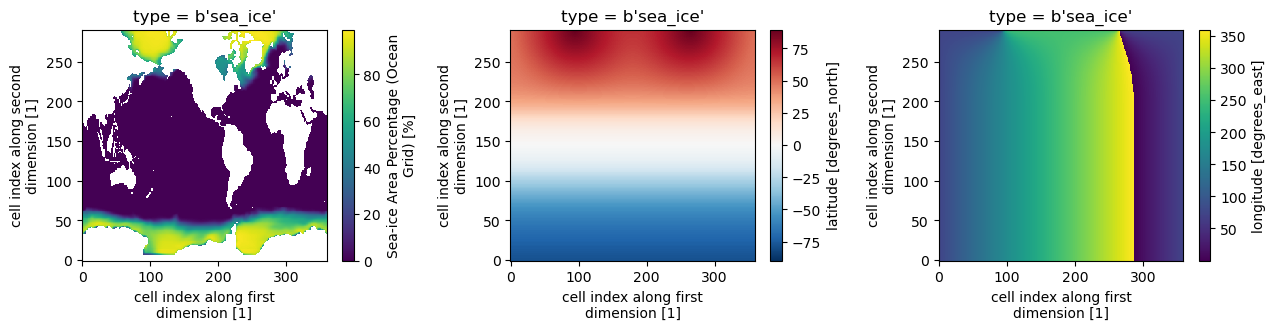

In [4]:
fig,ax=plt.subplots(1,3,figsize=(15,3))
axs=ax.flatten()
ds.siconc.plot(ax=axs[0])
ds.latitude.plot(ax=axs[1])
ds.longitude.plot(ax=axs[2])
plt.subplots_adjust(wspace=0.4)

CanESM5 ocean and sea ice output are on a tripolar grid, which is designed to deal with the fact that the North Pole falls in the ocean and sea ice (the models can't handle this because it's a singularity). 

<img src='https://www2.cesm.ucar.edu/models/cesm1.0/cesm/cesm_doc_1_0_4/tripolegrid.jpg' height=400 width=400></img>
<br><font size=1>Image Credit: [CESM](https://www2.cesm.ucar.edu/models/cesm1.0/cesm/cesm_doc_1_0_4/tripolegrid.jpg)</font>

Beyond the land distortion at the poles and Equator, the sea ice plot we made above might not look that bad to you overall. This is fine for a quick look, but things get weird when you try to make a plot that includes the latitude and longitude values:

In [ ]:
plt.contourf(ds.longitude, ds.latitude, ds.siconc)

Clearly, the irregularity of the 2D latitude and longitude fields is a problem for plotting.

><b><font color='red'>IMPORTANT:</font> If you want to show your model output on a nice cartopy map projection, cartopy won't know what to do (or it will do something really wonky) because your underlying data are not on a regular grid, and it doesn't have support for the specific curvilinear grids (tripolar, rotated pole in Greenland, etc) that climate models often use. This is where regridding is useful!</b> 

Let's go through the regridding process step-by-step:

#### 1. Set up your target grid
This is the new grid that you want your data to be on. There are a number of different ways to set up a target grid, so below are a couple of examples. The simplest way to set up a global grid is by using xESMF's built in [grid_global()](https://pangeo-xesmf.readthedocs.io/en/stable/user_api.html#xesmf.util.grid_global) function.

In [1]:
#1. Simplified set-up for a new global target grid
#Define the target grid (the new grid you want your output on), in this case 0.5 deg lat x 1 deg lon
target_grid=xe.util.grid_global(1.0, 0.5) #x-spacing, y-spacing

#2. Setting up a target grid to only regrid data in the northern hemisphere north of ~50N
#Start at ~50N, but do not include 90N otherwise cartopy gets rage-y (i.e. it doesn't work) when plotting
#lat=np.arange(49.4,90.0,0.5) 
#lon=np.arange(0.0,361.0,1.0)
#create a meshgrid (2D fields of lats and lons)
#lon2d,lat2d=np.meshgrid(lon,lat) 
#set up the target grid as an xarray Dataset
#target_grid=xr.Dataset({'lat': (['y', 'x'], lat2d),'lon': (['y', 'x'], lon2d)})

NameError: name 'xe' is not defined

Take a look at the target grid we created:

---

#### <font color='blue'>Question for the class</font>
What do lat_b and lon_b represent?

If it's hard for you to visualize the fields, run the code below to plot a subset of the grid points from the target grid:

In [ ]:
#get a subset of the grid for plotting
tg_slice=target_grid.sel(x=slice(0,5),y=slice(0,5),x_b=slice(0,5),y_b=slice(0,5))
#set up plot
fig,ax=plt.subplots(figsize=(4,4))
#add gridlines
ax.grid()
#plot lat and lon
ax.scatter(tg_slice.lon,tg_slice.lat,color='goldenrod')
#plot lat_b and lot_b
ax.scatter(tg_slice.lon_b,tg_slice.lat_b,color='darkmagenta',zorder=3)

---

#### 2. Set up the regridder
We'll use nearest_s2d in this example. 

<b><font color='red'>A couple of important things:</font></b>
>1. If the coordinates of your data are **NOT** named lat/lon or latitude/longitude, you MUST rename them to lat/lon so that xESMF can understand that these are the lat/lon fields, otherwise it has no way to guess. If your data is in xarray, you can rename coordinates using the [rename](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.rename.html) function.
>2. If you are using the conservative regridding option, <u>your data and your target grid must provide latitude and longitude bounds</u> (the grid cell corners/edges) otherwise xESMF will not be able to apply this method.
>3. If you are regridding on a global map, you probably want to set `periodic=True` so that your regridded output is periodic in longitude
>4. During regridding a weight file is created that is used to transform your data from the original grid to the new grid. This is typically the most time consuming part of the regridding operation, so once you've created it, if you plan to use the same weight file again, you can set `reuse_weights=True` so that the weight file can be reused when repeating the same regridding operation in the future, instead of having to recreate it from scratch every time you do the same regridding operation.</blockquote>

In [ ]:
#input grid, output grid, method, keyword arguments
regridder=xe.Regridder(ds.siconc, target_grid, 'nearest_s2d',periodic=True,reuse_weights=False)

#### 3. Do the regridding
Here we're only regridding one variable (the only one in the dataset), but note that you can [regrid multiple variables at once](https://xesmf.readthedocs.io/en/latest/notebooks/Dataset.html) by regridding an entire xarray dataset instead of a single DataArray.

In [ ]:
siconc_regrid=regridder(ds.siconc)

Let's plot the original output as well as the regridded output for comparison:

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(10,3))
axs=ax.flatten()
ds.siconc.plot(ax=axs[0])
axs[0].set_title('Original')
siconc_regrid.plot(ax=axs[1])
axs[1].set_title('Regridded')
plt.subplots_adjust(wspace=0.3)

---

#### <font color='blue'>Question for the class</font>

What are some similarities and differences that you notice between the plots?

---